In [142]:
import os
import glob
import datetime
import cftime
from collections import Counter
import calendar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import genextreme as gev

from unseen import fileio
from unseen import time_utils
from unseen import indices
from unseen import general_utils

In [2]:
# Parameters
dpi = 300

In [3]:
# Parameters
shapefile = "/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp"
metadata_file = "/home/599/dbi599/forks/unseen/config/dataset_agcd_daily.yml"
rx15day_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
region_name = "east-coast-flood-region"


In [4]:
assert os.path.isfile(metadata_file), "Must provide a metadata file (papermill option -p metadata_file [filepath])"
assert os.path.isfile(shapefile), "Must provide a shapefile (papermill option -p shapefile [filepath])"
assert 'rx15day_file' in locals(), "Must provide an rx15day output file (papermill option -p rx15day_file [filepath])"
assert 'region_name' in locals(), "Must provide a region name (papermill option -p region_name [name])"

## Spatially aggregated data

In [5]:
agcd_files = glob.glob('/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_*_daily.nc')
agcd_files.sort()

In [7]:
ds_list = []
for infile in agcd_files:
    print(infile)
    ds = fileio.open_dataset(
        infile,
        metadata_file=metadata_file,
        shapefile=shapefile,
        variables=['pr'],
        spatial_agg='mean', 
    )
    ds = ds.compute()
    ds_list.append(ds)

/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19000101-19001231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19010101-19011231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19020101-19021231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19030101-19031231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19040101-19041231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19050101-19051231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19060101-19061231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19070101-19071231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19080101-19081231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19090101-19091231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_1910

/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19890101-19891231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19900101-19901231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19910101-19911231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19920101-19921231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19930101-19931231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19940101-19941231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19950101-19951231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19960101-19961231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19970101-19971231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_19980101-19981231_daily.nc
/g/data/xv83/agcd-csiro/precip/daily/precip-total_AGCD-CSIRO_r005_1999

In [8]:
ds = xr.concat(ds_list, dim='time')

In [9]:
ds

<xarray.Dataset>
Dimensions:  (time: 44655)
Coordinates:
  * time     (time) object 1900-01-01 09:00:00 ... 2022-04-05 09:00:00
Data variables:
    pr       (time) float32 2.563 0.275 0.1135 0.3795 ... 1.334 7.708 0.7992
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 14:23:23 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

In [10]:
ds = ds.compute()

In [146]:
ds_monthly_totals = ds.resample({'time': 'M'}).sum('time', keep_attrs=True)
ds_monthly_totals

<xarray.Dataset>
Dimensions:  (time: 1468)
Coordinates:
  * time     (time) object 1900-01-31 00:00:00 ... 2022-04-30 00:00:00
Data variables:
    pr       (time) float32 70.37 57.06 83.3 64.27 ... 166.4 316.7 326.6 15.97
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 14:23:23 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

In [147]:
ds_monthly_clim = ds_monthly_totals.groupby('time.month').mean('time', keep_attrs=True)
ds_monthly_clim

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    pr       (month) float32 120.4 126.7 121.9 83.53 ... 48.98 71.88 84.8 103.9
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    history:                       Tue Sep 03 14:23:23 2019: cdo -O -z zip_4 ...
    institution:                   Australian Bureau of Meteorology, GPO Box ...
    Conventions:                   CF-1.6
    geospatial_lat_min:            -44.525
    geospatial_lat_max:            -9.975
    ...                            ...
    url:                           http://www.bom.gov.au/climate/
    licence:                       Copyright for any data supplied by the Bur...
    id:                            Australian Gridded Climate Data (AGCD)
    summary:                       The daily and monthly rainfall data repres...
    naming_authority:              au.gov.bom
    CDO:                           Climate Data Operators version 1.7.0 (http...

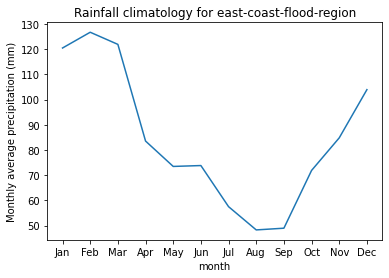

In [148]:
ds_monthly_clim['pr'].plot()
plt.ylabel('Monthly average precipitation (mm)')
plt.title(f'Rainfall climatology for {region_name}')
xticks = np.arange(1,13)
xlabels = [calendar.month_abbr[i] for i in xticks]
plt.xticks(xticks, xlabels)
plt.show()

## Calculate rx15day

In [123]:
def str_to_cftime(datestring, cftime_type):
    """Convert a date string to cftime object"""

    dt = datetime.datetime.strptime(datestring, "%Y-%m-%d")
    cfdt = cftime_type(dt.year, dt.month, dt.day)

    return cfdt


def calc_rx15day(ds):
    """Calculate rx15day values and event dates"""
    
    ds_15day = ds.rolling({'time': 15}).sum(keep_attrs=True)

    ds_rx15day = time_utils.temporal_aggregation(ds_15day, 'A-AUG', 'D', 'max', ['pr'])
    cftime_type = type(ds_rx15day['time'].values[0])

    ds_rx15day_argmax = ds_15day.resample(time='A-AUG', label='left', loffset=datetime.timedelta(days=1)).reduce(np.nanargmax, dim='time')
    time_diffs = ds_rx15day_argmax['pr'].values.astype('timedelta64[D]')
    str_times = [time.strftime("%Y-%m-%d") for time in ds_rx15day_argmax['time'].values]
    event_datetimes_np = np.array(str_times, dtype='datetime64') + time_diffs
    event_datetimes_str = np.datetime_as_string(event_datetimes_np)
    event_datetimes_cftime = [str_to_cftime(time, cftime_type) for time in event_datetimes_str]
    ds_rx15day = ds_rx15day.assign(event_time=event_datetimes_cftime)
    
    return ds_rx15day

In [124]:
ds_rx15day = calc_rx15day(ds)

In [125]:
#time_stamp = datetime.datetime.now().strftime("%a %b %d %H:%M:%S %Y")
#ds_rx15day.attrs['history'] = f'{time_stamp}: /home/599/dbi599/east-coast-rain/AGCD_{region_name}.ipynb (git@github.com:AusClimateService/east-coast-rain)'
#fileio.to_zarr(ds_rx15day, rx15day_file)

## Analyse and plot Rx15day data

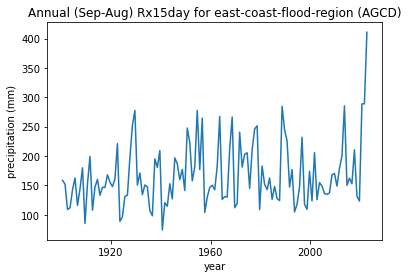

In [126]:
ds_rx15day['pr'].plot()
plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} (AGCD)')
plt.ylabel('precipitation (mm)')
plt.xlabel('year')
plt.savefig(
    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timeseries_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)
plt.show()

In [127]:
years = ds_rx15day['time'].dt.year.values
df_rx15day = pd.DataFrame(index=years)
df_rx15day['pr'] = ds_rx15day['pr'].values

In [128]:
df_rx15day['pr'].sort_values(ascending=False).head(n=10)

2022    410.744690
2021    288.879272
2020    288.798248
2013    285.407562
1988    284.566711
1954    277.744873
1929    277.528351
1963    267.536987
1968    266.335815
1956    264.522156
Name: pr, dtype: float64

In [129]:
rx15day_max = df_rx15day['pr'].values.max()
print(rx15day_max)

410.74468994140625


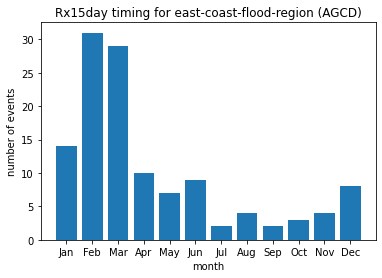

In [149]:
event_months = ds_rx15day['event_time'].dt.month.values
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} (AGCD)')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(xticks, xlabels)
plt.show()

In [20]:
def gev_analysis(ds, event, region, savefig=False):
    """Perform GEV analysis
    
    Args:
      ds (Pandas Series): Data sample
      event (float) : Event of interest
      region (str) : Name of spatial region
    """

    gev_shape, gev_loc, gev_scale = indices.fit_gev(ds.values)
    print(f'Shape parameter: {gev_shape:.2f}')
    print(f'Location parameter: {gev_loc:.2f}')
    print(f'Scale parameter: {gev_scale:.2f}')

    fig, ax = plt.subplots(figsize=[10, 8])
    gev_xvals = np.arange(0, 700)
    ds.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
    gev_pdf = gev.pdf(gev_xvals, gev_shape, gev_loc, gev_scale)
    plt.plot(gev_xvals, gev_pdf, color='tab:green', linewidth=4.0)
    plt.xlabel('precipitation (mm)')
    plt.ylabel('probability')
    plt.title(f'Annual (Sep-Aug) Rx15day for {region} (AGCD)')
    if savefig:
        plt.savefig(
            f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_AGCD_{region}.png',
            bbox_inches='tight',
            facecolor='white',
            dpi=dpi
        )
    plt.show()
    
    gev_data = gev.rvs(gev_shape, gev_loc, gev_scale, size=5000000)
    n_events, n_population, return_period, percentile = general_utils.event_in_context(gev_data, event, 'above')
    print(f'{n_events} events in {n_population} samples')
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period\n')

Shape parameter: -0.06
Location parameter: 142.63
Scale parameter: 38.90


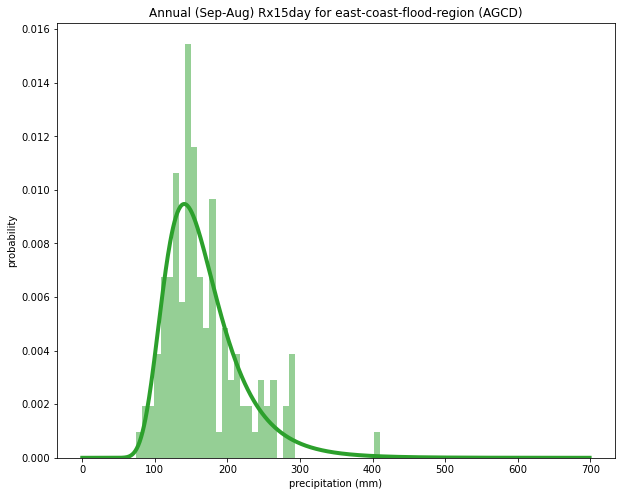

14884 events in 5000000 samples
99.70% percentile
336 year return period



In [21]:
gev_analysis(df_rx15day['pr'], rx15day_max, region_name, savefig=True)

Shape parameter: -0.01
Location parameter: 142.84
Scale parameter: 38.34


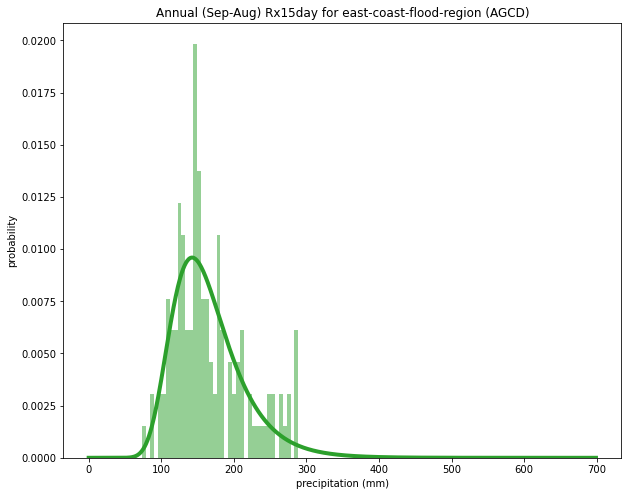

5757 events in 5000000 samples
99.88% percentile
869 year return period



In [22]:
gev_analysis(df_rx15day['pr'][:-1], rx15day_max, region_name)